# The Artwork Predictor
In this setction we take the four models and use then to: <br/>
- Predict the Artist of the Work of Art
- Predict the Genre
- Predict the Style
- Recommend five additional Artworks that complement the chosen Artwork.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.svm import SVC
from IPython.core.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

Use this setting to change between using _pre-built_ models or to build new models. <br>
__NOTE:__ the TRAIN dataset will not be uploaded to Github (_unless requested_) due to the size. Therefore this setting should be left as the default: <code>True</code>.

In [2]:
USE_PREBUILT_MODELS = True

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [3]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [4]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [5]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

Generate a one dimensional array of zeros the length of the target set. Unlike <code>dummy</code> this array of zeros is the full length of the target set and not the length of the provided data.

In [6]:
def generate_target_zeros(data, target_type):
    
    # generate a row of zeros with the target value set to 1
    def row_zeros(value):
        zeros_array = np.zeros((1,len(target_type)))
        zeros_array[0, target_type.index(value) ] = 1
        return zeros_array
    
    # generate all of the target rows
    array_of_rows = [row_zeros(x) for x in data["catagory"]]
    
    # return a target dataframe
    return pd.DataFrame(np.reshape(array_of_rows,(len(array_of_rows),len(target_type)) )).astype(int)

Display the artwork image associated with the given <code>image_tag</code> and label it with:
- the Title
- the Artist
- the Genre
- the Style
the image is loaded from file, whereas the details are extracted from the RDBMS.

In [7]:
# display an image file
def show_artwork(image_tag, data_set = TEST):

    #define variables
    data_file_path  = "./data/"
    image_file_path = "".join([data_file_path, "images/"]) 
    image_path      = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

    # Load the image
    artwork_image = Image.open(image_path).convert('RGB')

    # convert it into a numpy array
    img_array  = np.array(artwork_image)

    # define query to retrieve artwork information from the database
    query_string = """
SELECT TITLE,
       NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        title  = rec[1][0]
        artist = rec[1][1]
        genre  = rec [1][2]
        style  = ", ".join([rec[1][3], style  ]).strip(", ")

    # create a figure to grid plot into
    fig = plt.figure(figsize=(10, 8))

    # Plot the image
    plt.imshow(img_array)
    plt.xlabel("TITLE: {}\nARTIST: {}\nGENRE: {}\nSTYLE(S): {}".format(title, artist, genre, style), position=(0., 1e6), horizontalalignment='left')
    plt.xticks([])
    plt.yticks([])
    
    # show our handy work
    plt.show()    

The <code>image_tag</code> of the artwork is given. Using this, a query is performed against the RDBMS to retrieve:
- Artist name.
- Genre
- Style

In this case we are focusing on the Artist. So this value is stored as the correct value. <br/>
The artwork image features are retrieved and are used to make a prediction. <br/>
The predicted value and the correct value are compared. If they match then we have a correct prediction and the title of the plot is adjusted to state this. If we do not have a match, Then in this case we failed in our prediction. The plot title is adjusted to to say the prediction and the correct value. Finally, we plot the results.

In [8]:
def predict_and_plot_artist(image_tag):

    # get the artwork_id from the image tag
    image_tags  = read_data(IMAGE, TEST, ARTIST, IMAGE_TAG)
    filter      = image_tags["image_tag"] == selected_artwork_image_tag
    artwork_id  = image_tags[filter].index[0]
    
    # first we use the artwork_id to find key values from the database.
    # define query to retrieve artwork information 
    query_string = """
SELECT NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        artist = rec[1][0]
        genre  = rec [1][1]
        style  = ", ".join([rec[1][2], style  ]).strip(", ")
             
    #define variables
    column_names_list    = artists
    correct_value        = artist
    plot_title_label     = "Artist"

    # create a column heads dict from the list of artists
    i       = 0
    columns = {}
    for name in column_names_list:
        columns[i] = name
        i += 1

    # create a figure to grid plot into
    fig = plt.figure(figsize = (15, 8))

    # prepare subplot
    sp = 111
    plt.subplot(sp)

    # generate probability values for a single image
    data = pd.DataFrame(artist_model.predict_proba([read_data(IMAGE, TEST, ARTIST, DATA).iloc[artwork_id]]))

    # select highest probability as prediction
    prediction = column_names_list[data.idxmax(axis = 1)[0]]

    # create a second dataset containing just the value for the correct value. all
    # other values are set to zero. this is used to colour the plot.
    correct_value_data = np.zeros(len(column_names_list))
    
    # split on multiple values
    for value in correct_value.split(", "):
        correct_value_data[column_names_list.index(value)] = data[column_names_list.index(value)][0]
        
    # transform the data for the plot
    correct_value_data_t = pd.DataFrame(correct_value_data.T)
    
    # adjust output based on result. 
    if prediction in correct_value.split(", "):
        title  = "The Predicted {} is {} and we were Correct.".format(plot_title_label, prediction)
    else:
        title = "The Predicted {} is {}, but the Correct {} is {}.".format(plot_title_label, prediction, plot_title_label, correct_value)
    
    # format data for the plot
    data.rename(columns = columns, inplace = True) 
    data_t = data.T
    
    # define plot axis labels
    plt.ylim(0,1)
    plt.subplot(sp).tick_params(axis = "x", rotation = 90, labelsize = 14)

    # create subplot
    plt.bar(data_t.index, data_t[0], alpha = 1, color = "#1B9CFC")
    plt.bar(correct_value_data_t.index, correct_value_data_t[0], alpha = 1,   color = "#58B19F")

    # prepare figure 
    fig.subplots_adjust(top = 0.95)
    fig.suptitle(title, fontsize = 14)    
    
    # show our handy work
    plt.show() 
    
    # return the predicted artist name
    return prediction

The <code>image_tag</code> of the artwork of the artwork is given. Using this, a query is performed against the RDBMS to retrieve:
- Artist name.
- Genre
- Style

In this case we are focusing on the Genre. So this value is stored as the correct value. <br/>
The artwork image features are retrieved and are used to make a prediction. <br/>
If we have passed an Artists name as the <code>artist_weighting</code> value. Then this is also passed to the <codeget_prediction()</code> function along with the __TARGET__ type. This will cause the predicted result to be combined with the weighting values. <br/>
__NOTE:__ if used, the weights provide added domain knowledge to the prediction. The assumption is that the Artist has been identified correctly. Then, as we believe we know the Artist, we have some additional knowledge of the type of artwork Genre they produced and there fore adjust our prediction of the Genre to match the profile of the Artist. <br/>__E.g.__ an artist may be famous for their _Cityscapes_ but not for _Landscapes_. If we have a prediction that is _Landscape_ with the next highest value being_ Cityscape_. The _Landscape_ would be incorrectly chosen. But, if we apply the weighs. The _Cityscape_ prediction value will be elevated above _Landscape_. 

In [9]:
def predict_and_plot_genre(image_tag, artist_weighting = ""):

    # get the artwork_id from the image tag
    image_tags  = read_data(TILES, TEST, GENRE, IMAGE_TAG)
    filter      = image_tags["image_tag"] == selected_artwork_image_tag
    artwork_id  = image_tags[filter].index[0]
    
    # first we use the artwork_id to find key values from the database.
    # define query to retrieve artwork information 
    query_string = """
SELECT NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        artist = rec[1][0]
        genre  = rec [1][1]
        style  = ", ".join([rec[1][2], style  ]).strip(", ")
             
    #define variables
    column_names_list    = genres
    correct_value        = genre
    plot_title_label     = "Genre"

    # create a column heads dict from the list of artists
    i       = 0
    columns = {}
    for name in column_names_list:
        columns[i] = name
        i += 1

    # create a figure to grid plot into
    fig = plt.figure(figsize = (15, 8))

    # prepare subplot
    sp = 111
    plt.subplot(sp)

    # generate a filte using the image_tag then file the data. this should leave us with 64 tiles 
    filter        = read_data(TILES, TEST, GENRE, IMAGE_TAG)["image_tag"] == selected_artwork_image_tag
    filtered_data = read_data(TILES, TEST, GENRE, DATA)[filter]

    # call the model
    prediction1_data, prediction2_data, prediction_grid = get_prediction(genre_model, filtered_data, artist_weighting, "GENRE")
    
    # transform the data
    data  = pd.DataFrame(prediction2_data).T
  
    # convert the predicted value to a genre type name
    prediction = column_names_list[data.idxmax(axis = 1)[0]]
    
    # create a second dataset containing just the value for the correct value. all
    # other values are set to zero. this is used to colour the plot.
    correct_value_data = np.zeros(len(column_names_list))
    
    # split on multiple values
    for value in correct_value.split(", "):
        correct_value_data[column_names_list.index(value)] = data[column_names_list.index(value)][0]
         
    # transform and rescale the data
    correct_value_data_t = pd.DataFrame(correct_value_data.T).apply(lambda x: x / 64)
    
    # adjust output based on result. 
    if prediction in correct_value.split(", "):
        title  = "The Predicted {} is {} and we were Correct.".format(plot_title_label, prediction)
    else:
        title = "The Predicted {} is {}, but the Correct {} is {}.".format(plot_title_label, prediction, plot_title_label, correct_value)
    
    # format data for the plot
    data.rename(columns = columns, inplace = True) 
    
    # transform and rescale the data
    data_t = data.T.apply(lambda x: x / 64)
    
    # define plot axis labels
    plt.subplot(sp).tick_params(axis = "x", rotation = 90, labelsize = 14)

    # create subplot
    plt.bar(data_t.index, data_t[0], alpha = 1, color = "#1B9CFC")
    plt.bar(correct_value_data_t.index, correct_value_data_t[0], alpha = 1,   color = "#58B19F")

    # prepare figure 
    fig.subplots_adjust(top = 0.95)
    fig.suptitle(title, fontsize = 14)    
    
    # show our handy work
    plt.show() 

The <code>image_tag</code> of the artwork of the artwork is given. Using this, a query is performed against the RDBMS to retrieve:
- Artist name.
- Genre
- Style

In this case we are focusing on the Style. So this value is stored as the correct value. <br/>
The artwork image features are retrieved and are used to make a prediction. <br/>
If we have passed an Artists name as the <code>artist_weighting</code> value. Then like with the Genre prediction. The weights are retrieved from the RDBMS and applied to the prediction of the Style.

In [10]:
def predict_and_plot_style(image_tag, artist_weighting = ""):

    # get the artwork_id from the image tag
    image_tags  = read_data(TILES, TEST, STYLE, IMAGE_TAG)
    filter      = image_tags["image_tag"] == selected_artwork_image_tag
    artwork_id  = image_tags[filter].index[0]
    
    # first we use the artwork_id to find key values from the database.
    # define query to retrieve artwork information 
    query_string = """
SELECT NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        artist = rec[1][0]
        genre  = rec [1][1]
        style  = ", ".join([rec[1][2], style  ]).strip(", ")
             
    #define variables
    column_names_list    = styles
    correct_value        = style
    plot_title_label     = "Style"

    # create a column heads dict from the list of artists
    i       = 0
    columns = {}
    for name in column_names_list:
        columns[i] = name
        i += 1

    # create a figure to grid plot into
    fig = plt.figure(figsize = (15, 8))

    # prepare subplot
    sp = 111
    plt.subplot(sp)

    # generate a filte using the image_tag then file the data. this should leave us with 64 tiles 
    filter        = read_data(TILES, TEST, STYLE, IMAGE_TAG)["image_tag"] == selected_artwork_image_tag
    filtered_data = read_data(TILES, TEST, STYLE, DATA)[filter]

    # call the model
    prediction1_data, prediction2_data, prediction_grid = get_prediction(style_model, filtered_data, artist_weighting, "STYLE")
    
    # transform the data
    data       = pd.DataFrame(prediction2_data).T

    # convert the predicted value to a style type name
    prediction = column_names_list[data.idxmax(axis = 1)[0]]
    
    # create a second dataset containing just the value for the correct value. all
    # other values are set to zero. this is used to colour the plot.
    correct_value_data = np.zeros(len(column_names_list))
    
    # for styles it is possible to have multiple values. therefore we must apply a
    # split and loop through each value in the list. in most cases this will still
    # only be one. but, there are some special cases.
    for value in correct_value.split(", "):
        correct_value_data[column_names_list.index(value)] = data[column_names_list.index(value)][0]
         
    # transform and rescale the data
    correct_value_data_t = pd.DataFrame(correct_value_data.T).apply(lambda x: x / 64)

    # adjust output based on result. for style, if there are multiple values and 
    # one of them is predicted. we call it a success.
    if prediction in correct_value.split(", "):
        title = "The Predicted {} is {} and we were Correct.".format(plot_title_label, prediction)
    else:
        title = "The Predicted {} is {}, but the Correct {} is {}.".format(plot_title_label, prediction, plot_title_label, correct_value)
    
    # format data for the plot
    data.rename(columns = columns, inplace = True) 
    
    # transform and rescale the data
    data_t = data.T.apply(lambda x: x / 64)
    
    # define plot axis labels
    plt.ylim(0,1)
    plt.subplot(sp).tick_params(axis = "x", rotation = 90, labelsize = 14)

    # create subplot
    plt.bar(data_t.index, data_t[0], alpha = 1, color = "#1B9CFC")
    plt.bar(correct_value_data_t.index, correct_value_data_t[0], alpha = 1,   color = "#58B19F")

    # prepare figure 
    fig.subplots_adjust(top = 0.95)
    fig.suptitle(title, fontsize = 14)    
    
    # show our handy work
    plt.show() 

The <code>show_artwork_tiles()</code> function is designed to work with the tagets Genre & Style as the prediction of these is performed using the <code>TILE</code> target data. <br/>
The features of the tile images associated with the give <code>image_tag</code> are retrieved and are processed. Each of the 64 tile images returns a prediction. These predictions are stored. <br/>
We then loop through the 8 columns of each of the 8 rows of image tiles. The image tile is plotted and the border arond the image tile is colured to match the prediction. <br/>
Finally, we prepare the legend of prediction values. <br/>
The intention is to display which tiles are correctly identified as the artworks Genre, or Style. 

In [11]:
def show_artwork_tiles(image_tag, target, artist_weighting = ""):
    
    # identify the 64 image tiles with the given image_tag and create a filter
    filter = read_data(TILES, TEST, target, IMAGE_TAG)["image_tag"] == selected_artwork_image_tag

    # apply the filer to select just the 64 tiles
    filtered_data = read_data(TILES, TEST, target, DATA)[filter]

    # select the correct model depending on the target
    if target == GENRE:
        prediction1_data, prediction2_data, prediction_grid = get_prediction(genre_model, filtered_data, artist_weighting, "GENRE")
        
        # select the catagory of each prediction by finding the column containing a 1 and then identifying the corresponding label
        tiles_predicted_catagory = prediction_grid.apply(lambda x: genres[x[x == 1].index[0]] , axis = 1)
    else:
        prediction1_data, prediction2_data, prediction_grid = get_prediction(style_model, filtered_data, artist_weighting, "STYLE")
        
        # select the catagory of each prediction by finding the column containing a 1 and then identifying the corresponding label
        tiles_predicted_catagory = prediction_grid.apply(lambda x: styles[x[x == 1].index[0]] , axis = 1)        

    # the set of predicted catagory values
    tile_catagories   = tiles_predicted_catagory.tolist()

    # the unique set of predicted catagory values (duplicates removed)
    unique_catagories = tiles_predicted_catagory.unique().tolist()

    # tile border colours
    colours           = ["#FEA47F", "#25CCF7", "#EAB543", "#55E6C1", "#CAD3C8", "#F97F51", "#1B9CFC", "#F8EFBA", "#58B19F", "#2C3A47", "#B33771", "#3B3B98", "#FD7272", "#9AECDB", "#D6A2E8", "#6D214F", "#182C61", "#FC427B", "#BDC581", "#82589F", "#fa8231", "#FFFFFF"]

    # initialize the current tile value
    current_tile      = 0
    
    # create a figure to grid plot into
    fig = plt.figure(figsize=(10, 8))

    for row_no in range(0,8):

        # loop through the catagories
        for tile_no in range(0,8):
            
            # Load the image
            tile_image = Image.open("./data/tiles/{}/{}_{:02d}_{:02d}.png".format(image_tag, image_tag, row_no +1, tile_no +1)).convert('RGB')

            # Plot the image
            ax1 = plt.subplot(8,8,1 +(row_no *8) +tile_no)
            plt.imshow(tile_image)
            
            # remove ticks and labels
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            
            # border values
            border_colour = colours[unique_catagories.index(tile_catagories[current_tile])]
            border_width  = 5
            
            # create a colour border
            ax1.spines['bottom'].set_color(border_colour)
            ax1.spines['top'   ].set_color(border_colour)
            ax1.spines['left'  ].set_color(border_colour)
            ax1.spines['right' ].set_color(border_colour)
            ax1.spines['bottom'].set_linewidth(border_width)
            ax1.spines['top'   ].set_linewidth(border_width)
            ax1.spines['left'  ].set_linewidth(border_width)
            ax1.spines['right'] .set_linewidth(border_width)
            
            # increment the tile cound by one
            current_tile += 1
                   
    # prepare figure 
    fig.subplots_adjust(top=1.1, left=0.1)   

    # the list od entries for the legend
    mpatch = []
    
    # loop through the catagories and create the legend values
    for catagory in unique_catagories:
        patch = mpatches.Patch( label=catagory,  color=colours[unique_catagories.index(catagory)])
        mpatch.append(patch)
        
    # prepare figure 
    fig.legend(handles=mpatch, bbox_to_anchor=(1.14,1.11), bbox_transform=plt.gcf().transFigure)  
    
    # show our handy work
    plt.show() 

The <code>select_similar_artworks()</code> function will choose artworks with similar visual characteristics to that  of the artwork those <code>image_tag</code> provided. There is also the optional parameter <code>no_of_artworks</code> which allows the user to define how many images should be selected. (_If no value is provided, then the default value of: _5_ is used_). <br/>
The image features of the selected artwork are loaded and compared the the image features of the other artworks.<br/>
With the similar images selected, the original image and it's _n_ neighbors are looped through. They are plotted, their details are extracted from the RDBMS and shown directly below. The first image (_the original selected artwork_) has the additional prefix to the details <code>YOUR SELECTED ARTWORK\n</code> inserted.

In [12]:
def select_similar_artworks(image_tag, no_of_artworks = 5):
    
    # the variable neighbors is the parameter no_of_artworks incremented by 1. this is because 
    # the the first image will be that of the selected artwork.
    neighbors = no_of_artworks + 1
        
    # get the artwork_id from the image tag
    image_tags  = read_data(IMAGE, TEST, ARTIST, IMAGE_TAG)
    filter      = image_tags["image_tag"] == selected_artwork_image_tag
    artwork_id  = image_tags[filter].index[0]
        
    # set neighbors
    knn_neighbors = NearestNeighbors(n_neighbors = neighbors)
    
    # fit estimator
    knn_neighbors.fit(read_data(IMAGE, TEST, ARTIST, DATA), 
                      read_data(IMAGE, TEST, ARTIST, CATAGORY))

    # identify the nearest neighbors
    nearest_neighbors = knn_neighbors.kneighbors([read_data(IMAGE, TEST, ARTIST, DATA).iloc[artwork_id]])

    # find the indexes of the nearest neighbors
    nearest_neighbors_indexes = nearest_neighbors[1][0]
    
    # create a figure to grid plot into
    fig = plt.figure(figsize=(25, 10))

    # calculate the number of rows and columns to display the artwork images
    columns  = int(np.ceil(neighbors/2))
    rows     = int(np.ceil(neighbors/5)+1)
    position = 0

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")

    # define the additional message that is only to be displayed with the first image plot
    your_selected_artwork_message = "YOUR SELECTED ARTWORK\n"
    
    # loop through the neighbors
    for neighbor_index in nearest_neighbors_indexes:
    
        # define the image filename
        data_file_path  = "./data/"
        image_file_path = "".join([data_file_path, "images/"]) 
        image_tag       = read_data(IMAGE, TEST, ARTIST, IMAGE_TAG)["image_tag"][neighbor_index]
        image_path      = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

        # Load the image
        input_img = Image.open(image_path).convert('RGB')
    
        # convert it into a Numpy array
        img = np.array(input_img)

        # Flatten the array
        flat_img = img.flatten()
    
        # Plot the image
        position = position + 1
    
    # define query to retrieve artwork information from the database
        query_string = """
SELECT TITLE,
       NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

        # execute query
        lookup = pd.read_sql_query(query_string, conn)
    
        # extract the values from the returned dataset
        style = ""
        for rec in lookup.iterrows():
            title  = rec[1][0]
            artist = rec[1][1]
            genre  = rec [1][2]
            style  = ", ".join([rec[1][3], style  ]).strip(", ")
    
        # Plot the image
        plt.subplot(rows, columns, position)
        plt.imshow(img)
        plt.xlabel("{}TITLE: {}\nARTIST: {}\nGENRE: {}\nSTYLE(S): {}".format(your_selected_artwork_message, title, artist, genre, style), position=(0., 1e6), horizontalalignment='left')
        plt.xticks([])
        plt.yticks([])
        
        # set this message to an empty string so that is is only displayed when plotting the first image
        your_selected_artwork_message = ""

    # prepare figure 
    fig.subplots_adjust(top=1.7)   
    
    # show our handy work
    plt.show()   

The <code>get_prediction()</code> function recieves a <code>model</code> and the prediction data. (_The prediction data can be either a single set of features, such as from an image. Or, a set of image featurs, such as the set of 64 tile images_). The data is iterated through and the one to many predictions are stored in prediction _percentage_ and _binary_ formats. Finally the _percentage_ values and the _binary_ values are totalled and returen along with the full set of binary results.

In [13]:
def get_prediction(model, data_set, artist_weighting = "", target = ""):

    # create dataframes to hold the prediction results
    prediction1_results = pd.DataFrame() # rediction values
    prediction2_results = pd.DataFrame() # binary prediction values

    # Rescale train and validation data
    scaler   = StandardScaler()
    data_set = pd.DataFrame(scaler.fit_transform(data_set.astype(float)) )
    
    # when weighting is to be applied
    if artist_weighting > "" and target > "":
        
        # set apply weights flag
        apply_weights = True
        
        # construct the query to extract the weights
        query_string = """
SELECT {}_ID,
       1 + PERCENTAGE weight
FROM ARTIST        AS A,
     ARTIST_{}  AS B
WHERE A.NAME = "{}"
AND   A.ID = B.ARTIST_ID
""".format(target, target, artist_weighting)
        
        # connect to the database
        conn       = sqlite3.connect("./data/database/artist.db")

        # execute query
        weightings = pd.read_sql_query(query_string, conn)
        
        # the id filed in the returned data
        id_field   = "".join([target.lower(), "_id"])
           
    else:
        # set apply weights flag
        apply_weights = False

    # loop through the set of 64 tiles
    for data in data_set.iterrows():

        # generate the tile pediction
        prediction = model.predict(pd.DataFrame(data[1]).T)

        if apply_weights:
            # transform data
            prediction = prediction.T
            
            # apply the weights
            for _, row_data in weightings.iterrows():
                prediction[int(row_data[id_field])] = prediction[int(row_data[id_field])] * row_data["weight"]
                
            # transform data
            prediction = prediction.T

        # prediction values
        prediction1_results = prediction1_results.append(pd.DataFrame(prediction))
        
        # binary prediction values
        prediction2_results = prediction2_results.append(pd.DataFrame(1 * (prediction == prediction.max())))
        
    # the prediction results summary, the binary prediction results totals summary and the table of 64 binary results
    return prediction1_results.sum(), prediction2_results.sum(), prediction2_results

A simple function to set the index of a prediction array to the relivant catagory labels.

In [14]:
def label_prediction(prediction_data, labels):
    
    # get the catagory labels
    prediction_data.index = labels
    
    # return the labels
    return prediction_data

## Define the Models
The construction of the _Support Vector Machine_ Classifier used for predicting the Artist. <br/>
__NOTE:__ The model definition functions are only called if the <code>USE_PREBUILT_MODELS</code> variable is set to <code>False</code>.

In [15]:
def build_artist_model():
    
    # prepare data
    X_train = read_data(IMAGE, TRAIN, ARTIST, DATA    )
    y_train = read_data(IMAGE, TRAIN, ARTIST, CATAGORY)

    # create our pipeline 
    model = make_pipeline(StandardScaler(),
                          SVC(C           = 10.0, 
                              gamma       = "scale", 
                              kernel      = "rbf",
                              probability = True))

    # fit the data
    model.fit(X_train, y_train)
    
    # return teh model
    return model

The construction of the _Dense Neural Network_ Classifiers for the prediction of the Genre.

In [16]:
def build_genre_model():
    # import the training data
    X_train = read_data(TILES, TRAIN, GENRE, DATA)
    y_train = generate_target_zeros(read_data(TILES, TRAIN, GENRE, CATAGORY), genres)

    # import the test data
    X_test  = read_data(TILES, TEST,  GENRE, DATA)
    y_test  = generate_target_zeros(read_data(TILES, TEST,  GENRE, CATAGORY), genres)

    # construct the model
    model = Sequential()
    model.add(Dense( 1280 // 2, 
                     input_shape        = (1280,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense( 1280 // 4, 
                     input_shape        = (1280 // 2,), 
                     activation         = "elu"))

    model.add(Dense( 1280 // 8, 
                     input_shape        = (1280 // 4,), 
                     activation         = "selu"))

    model.add(Dense( len(genres), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    # set the pressing batch size
    batch_size = 256

    # compile the model
    model.compile( loss      = keras.losses.binary_crossentropy,
                   optimizer = keras.optimizers.SGD(lr       = 0.1, 
                                                    momentum = 0.9),  
                   metrics   =['accuracy'])

    # Rescale train and validation data
    scaler               = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train.astype(float))
    X_test_preprocessed  = scaler.transform(    X_test.astype( float))

    # fit the model
    model.fit(X_train_preprocessed,
              y_train,
              batch_size       = batch_size, 
              validation_split = 0.2,
              epochs           = 25,
              shuffle          = True )
    
    return model

The construction of the _Dense Neural Network_ Classifiers for the prediction of the Genre.

In [17]:
def build_style_model():
    # import the training data
    X_train = read_data(TILES, TRAIN, STYLE, DATA)
    y_train = generate_target_zeros(read_data(TILES, TRAIN, STYLE, CATAGORY), styles)

    # import the test data
    X_test  = read_data(TILES, TEST,  STYLE, DATA)
    y_test  = generate_target_zeros(read_data(TILES, TEST,  STYLE, CATAGORY), styles)

    # construct the model
    model = Sequential()
    model.add(Dense( 1280 // 2, 
                     input_shape        = (1280,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense( 1280 // 4, 
                     input_shape        = (1280 // 2,), 
                     activation         = "relu"))


    model.add(Dense( len(styles), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    # set the pressing batch size
    batch_size = 256

    # compile the model
    model.compile( loss      = keras.losses.binary_crossentropy,
                   optimizer = keras.optimizers.SGD(lr       = 0.01, 
                                                    momentum = 0.9),  
                   metrics   =['accuracy'])

    # Rescale train and validation data
    scaler               = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train.astype(float))
    X_test_preprocessed  = scaler.transform(    X_test.astype( float))

    # fit the model
    model.fit(X_train_preprocessed,
              y_train,
              batch_size       = batch_size, 
              validation_split = 0.2,
              epochs           = 25,
              shuffle          = True )
    
    return model

## Build New Models or Load Pre-built Models
Depending on the value of the _Global_ Variable: __USE_PREBUILT_MODELS__ we either: <br/>
__True:__
- load a previously created model

__False:__
- process the TRAINING data
- build the model
- save the model for persistance
- load the model into a variable

__NOTE:__ The TRIANING data is quite large and therefore has not been uploaded to Github. Instead just prebuilt models have been created and uploaded. The full data can be provided if required. <br/>
<br/>
The __ARTIST__ model.

In [18]:
if USE_PREBUILT_MODELS == False:

    # build a new model and save it to file
    joblib.dump(build_artist_model(), "./data/models/artist.model")

# import a previously built model
artist_model =  joblib.load("./data/models/artist.model")

The __GENRE__ model.

In [19]:
if USE_PREBUILT_MODELS == False:

    # build a new model and save it to file
    build_genre_model().save("./data/models/genre.model")

# import a previously built model
genre_model = keras.models.load_model("./data/models/genre.model")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The __STYLE__ model.

In [20]:
if USE_PREBUILT_MODELS == False:

    # build a new model and save it to file
    build_style_model().save("./data/models/style.model")

# import a previously built model
style_model = keras.models.load_model("./data/models/style.model")

## Test the Models
With the Models built we are ready to try them out.

In [21]:
# generate some html containing a list aof all of the image_tags for the images in the test dataset
tags = pd.DataFrame(read_data(TILES, TEST, ARTIST, IMAGE_TAG)["image_tag"].unique()).sort_values(0).T
display(HTML( "".join(["""<b>NOTE:</b> (<i>This has been added for the ease of the enduser</i>). Here are a list of <b>IMAGE_TAGS</b> fromt the TEST dataset. <b>SELECT AN IMAGE_TAG AND PLACE IT BETWEEN THE DOUBLE QUOTES IN THE CELL BELOW</b>...<br/>""", str(tags.values[0]).replace("\n", "").replace(" ", ",  ").replace("'", "").replace("[", "").replace("]", "")]) ))

In [32]:
# define the image to process
selected_artwork_image_tag = "04_0015".strip()   # <--- PLACE A VALID TEST DATA IMAGE_TAG HERE!!!  

# 00_0018 Anges Martin
# 01_0144 Berthe Morisot
# 02_0011 Edward Hicks
# 03_0016 Goya
# 04_0015 Henry Fuseli
# 05_0053 Jackson Pollock
# 06_0058 Karl Bodmer
# 07_0011 Katsushika Hokusai
# 08_0037 L S Lowery
# 10_0069 Picasso
# 10_0900 Picasso (demo bad labelling)
# 11_0071 Piet Mondrian
# 12_0140 Roy Lichtenstein
# 13_0004 Tamara de Lempida (start image)
# 13_0084 Tamara de Lempida

# sanity check to make sure that it does belong to the TEST data set
if selected_artwork_image_tag not in read_data(TILES, TEST, ARTIST, IMAGE_TAG)["image_tag"].values:
    sys.stdout.write("\rERROR - The IMAGE_TAG {} is not in the TEST data set. Please select a value from the list above.".format(selected_artwork_image_tag))

## The Image of the Artwork that You Have Selected
Details of the Artwork are displayed below it.

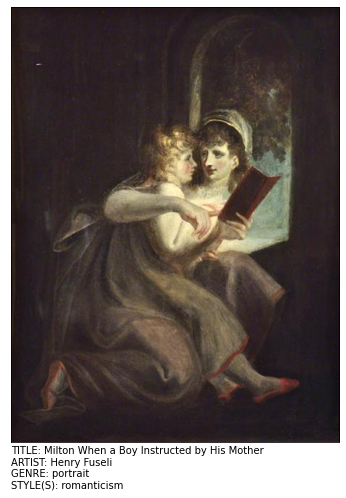

In [33]:
show_artwork(selected_artwork_image_tag)

## __GOAL 1__ - Predict the Artist
To predict the Artist we use the _Support Vector Machine_ Classification Model. <br/>
__NOTE:__ our prediction is the highest bar in the plot. The Title of the plot details the prediction and the actual Artist.

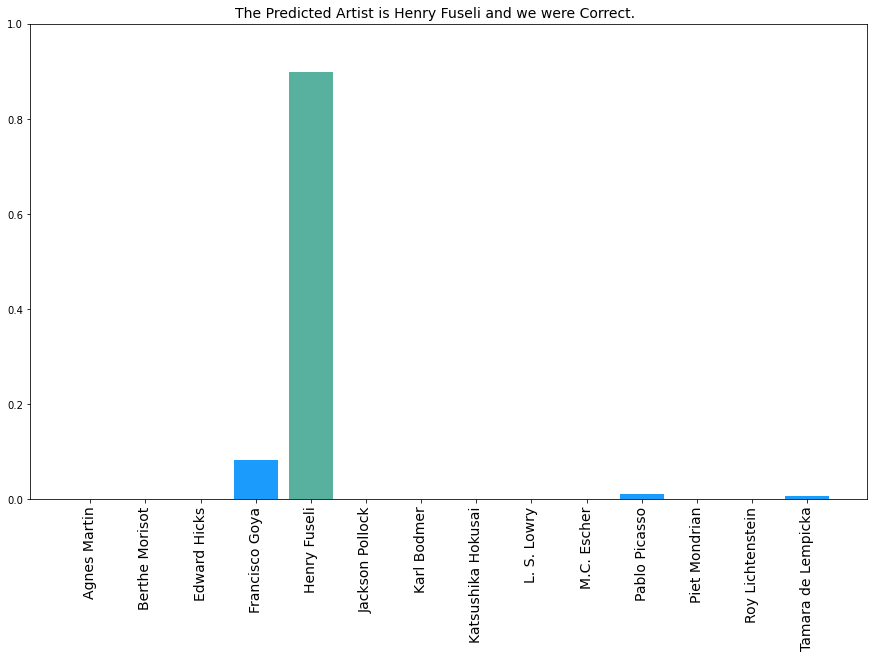

In [34]:
predicted_artist = predict_and_plot_artist(selected_artwork_image_tag)

## __GOAL 2__ - Predict Genre & Style

## Predicting the Genre
To predict the Genre we use the first of our _Dense Neural Network_ Classification Models. <br/>
__NOTE:__ our prediction is the highest bar in the plot. The Title of the plot details the prediction and the actual Artist. The correct Genre is also marked in Green.

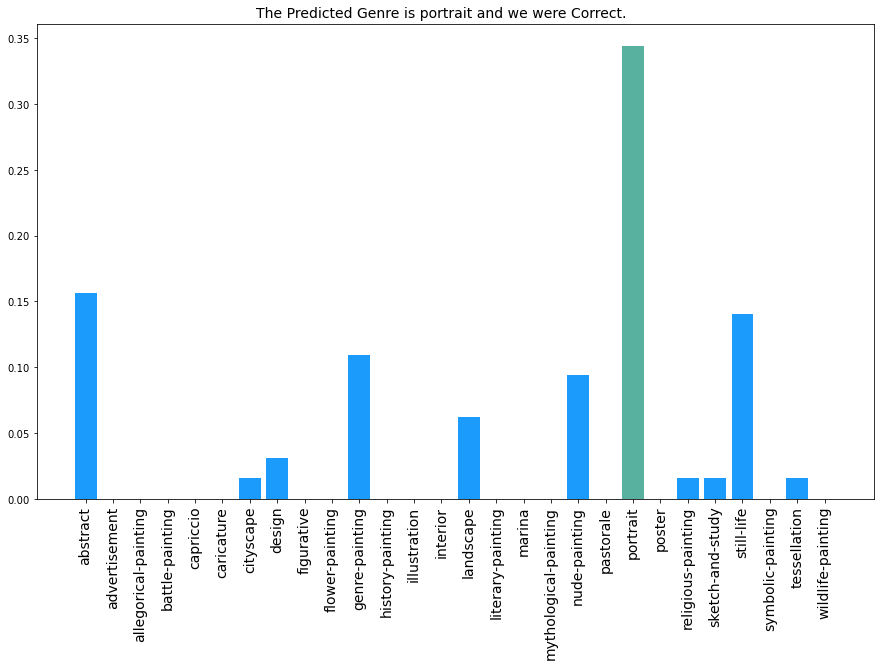

In [35]:
predict_and_plot_genre(selected_artwork_image_tag)

## Predicting the Genre Using Pre-defined Weights
__NOTE:__ When we call the <code>predict_and_plot_genre()</code> function we can also provide an Artist name. If we do this a set of weights are multiplied with the prodiction values. These weights are from the _ARTIST_GENRE_ table of the database. From the recorded body of work of the Artist. We know which _Genres_ they specialized in and which they ignored. We also know the aproximate ratios of the different Genres. By using this additional information we are able to modify the models preditions. Here we rely on the accurancy of the Artist prediction. The _redict_and_plot_artist_ function returns the predicted Artist, which we collect and pass.

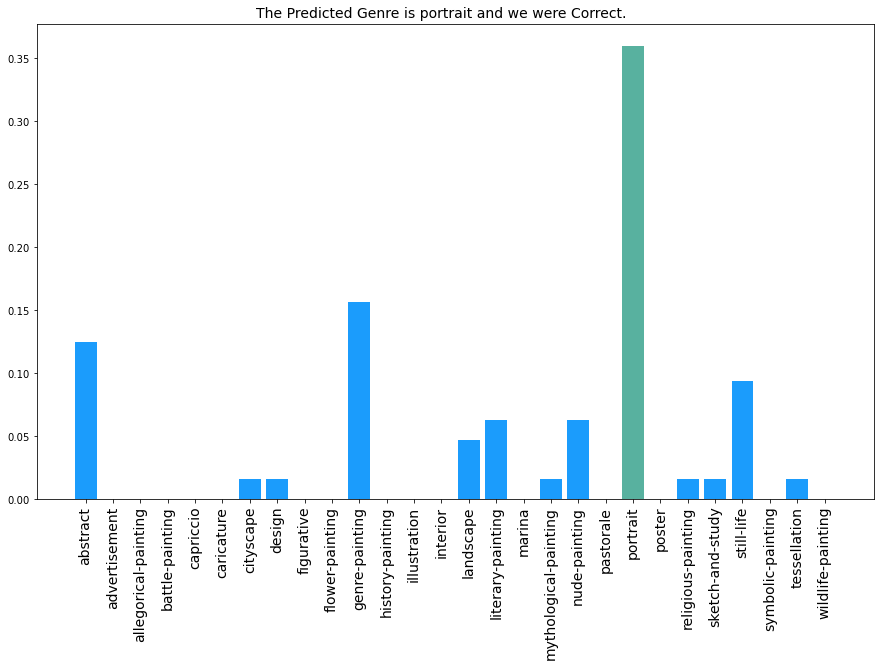

In [36]:
predict_and_plot_genre(selected_artwork_image_tag, predicted_artist)

## A Closer Look at the Predictions of the Genre Dense Neural Net by Vistualizing the Prediction of each Tile
The tiles based prediction of the Dense Neural Net generate 64 predictions that are combined for the final result. To visualize thes prediction each tile is displayed with a border colour representing its predicted Genre. <br/>
__NOTE:__ The results are a little disappointing. I would have expected to see a lesser number of GENRES listed. _Never the less_, It is a nice way to view the results.

Without Weighing


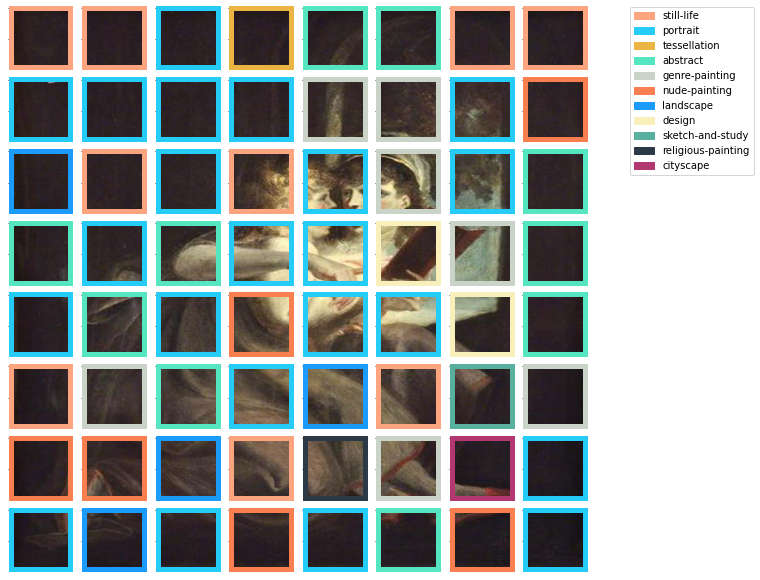

With Weights Applied


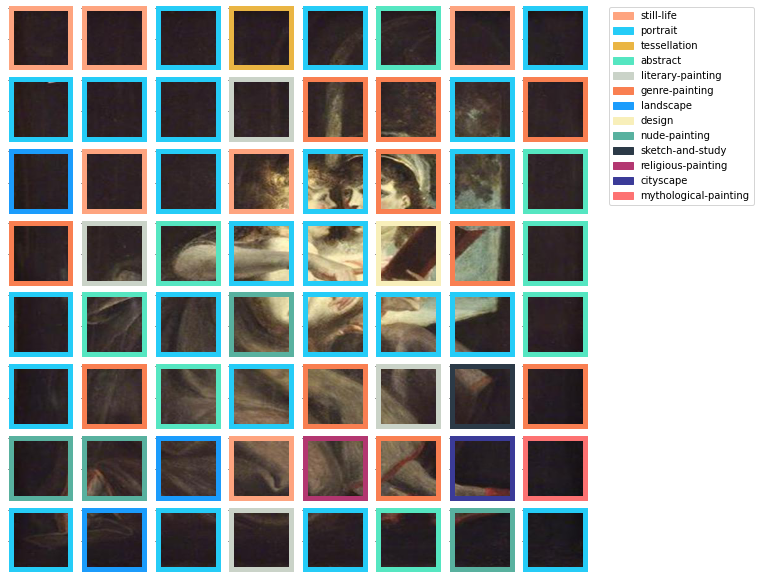

In [37]:
print("Without Weighing")
show_artwork_tiles(selected_artwork_image_tag, GENRE)
print("With Weights Applied")
show_artwork_tiles(selected_artwork_image_tag, GENRE, predicted_artist)

## Predicting the Style
To predict the Style we use the second of our _Dense Neural Network_ Classification Models. <br/>
__NOTE:__ our prediction is the highest bar in the plot. The Title of the plot details the prediction and the actual Style. The correct Style is also marked in Green.

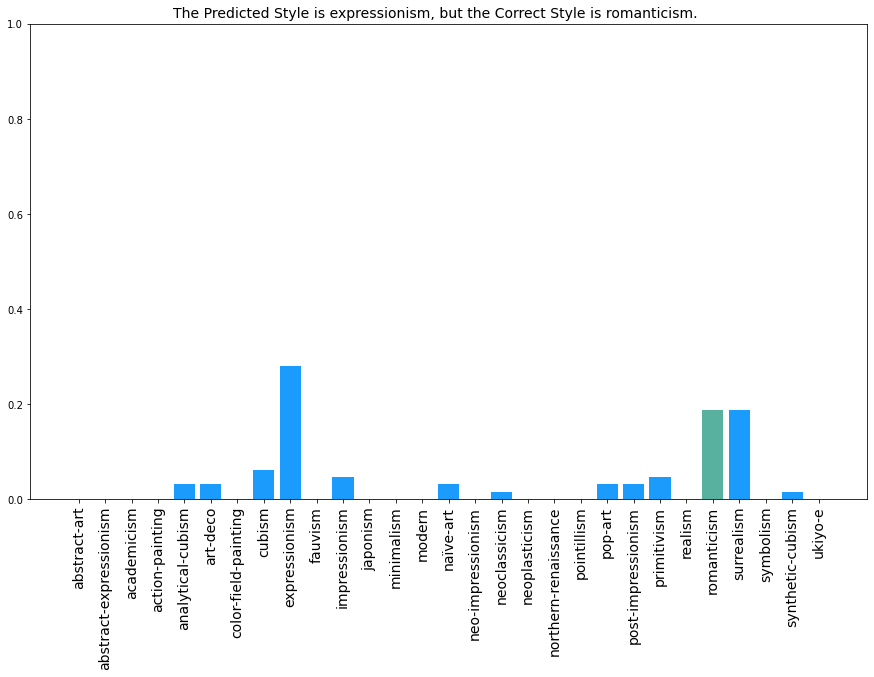

In [38]:
predict_and_plot_style(selected_artwork_image_tag)

## Predicting the Style Using Pre-defined Weights
As with the function <code>predict_and_plot_style()</code>, the function _predict_and_plot_style_ allows the passing of the Artist to apply weighting to the predictions. This time the weights are from the database table _ARTIST_STYLE_.

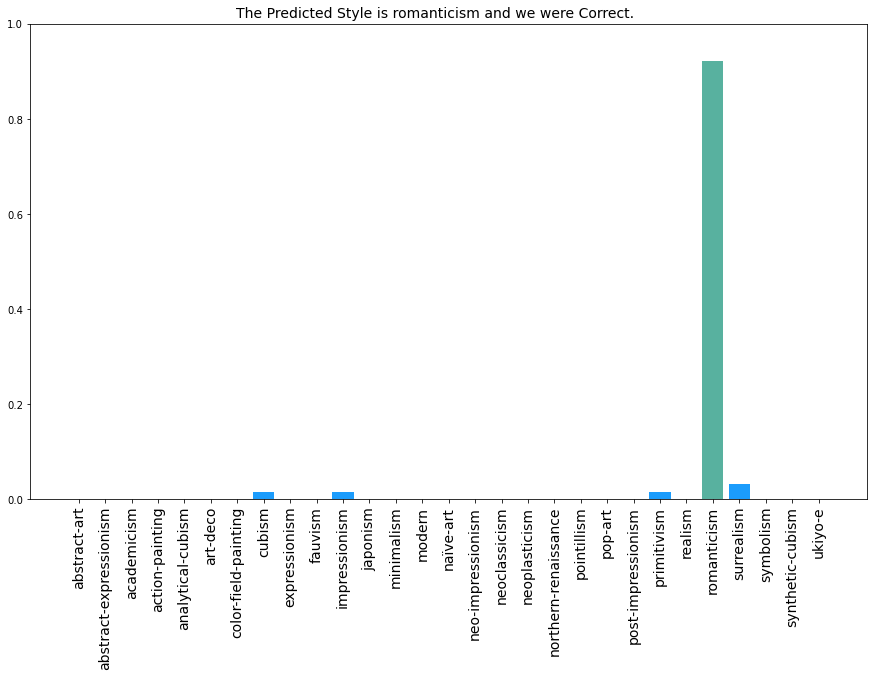

In [39]:
predict_and_plot_style(selected_artwork_image_tag, predicted_artist)

## A Closer Look at the Predictions of the Style Dense Neural Net by Vistualizing the Prediction of each Tile
The tiles based prediction of the Dense Neural Net generate 64 predictions that are combined for the final result. To visualize thes prediction each tile is displayed with a border colour representing its predicted Genre. <br/>
__NOTE:__ Again, the results are a little disappointing. I would have expected to see a lesser number of STYLES listed. _Never the less_, It is a nice way to view the results.

Without Weighing


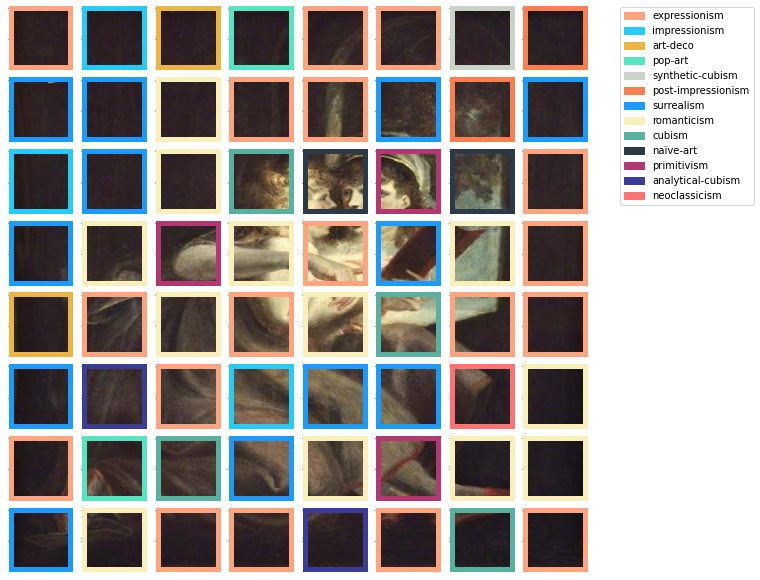

With Weights Applied


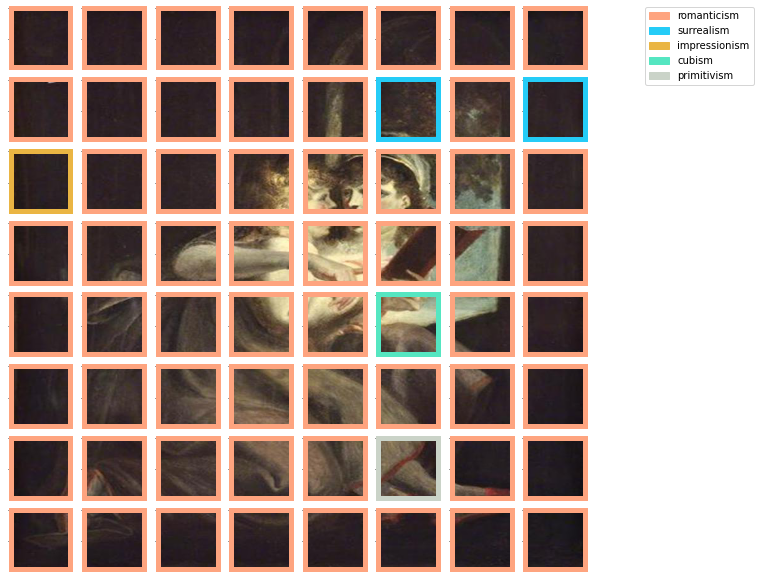

In [40]:
print("Without Weighing")
show_artwork_tiles(selected_artwork_image_tag, STYLE)
print("With Weights Applied")
show_artwork_tiles(selected_artwork_image_tag, STYLE, predicted_artist)

## __GOAL 3__ - Because You Chose, _You Might also Like..._
Here we show the selected artwork and 5 additional artworks that have a similar visual appearance. <br/>
If you wish to build a collection of Artworks that would complement each other. Thene here are some recommendations...

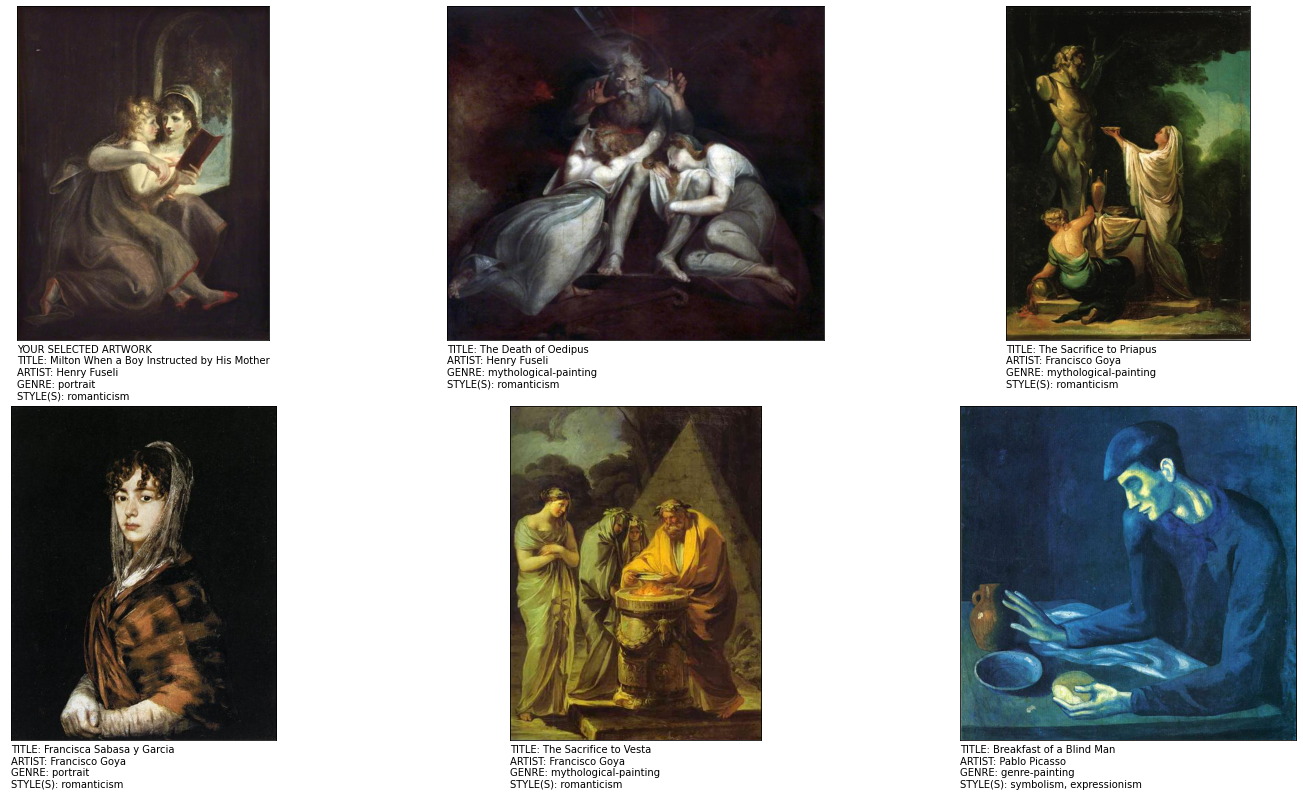

In [41]:
select_similar_artworks(selected_artwork_image_tag)